## Download Data & Import Packages

In [ ]:
!gdown --id "1qnQ-ar7_Ga2NZlna-rQF2JcRl_sYDL-1"
!unzip archive.zip
!rm archive.zip
# %cd archive
!gdown --id "1U76GwXl4OHlTom10UqKCGwI88zfH7dNS"
!gdown --id "1LGYpA0FgafuFlj8GrYwlK_0P7C0v7S0A"
!unzip berlin.zip
!rm berlin.zip
!pip install geopandas

Downloading...
From: https://drive.google.com/uc?id=1qnQ-ar7_Ga2NZlna-rQF2JcRl_sYDL-1
To: /content/archive.zip
100% 96.2M/96.2M [00:01<00:00, 70.3MB/s]
Archive:  archive.zip
   creating: archive/
  inflating: __MACOSX/._archive      
  inflating: archive/bezirksgrenzen.shx  
  inflating: __MACOSX/archive/._bezirksgrenzen.shx  
  inflating: archive/bezirksgrenzen.shp  
  inflating: __MACOSX/archive/._bezirksgrenzen.shp  
  inflating: archive/reviews.csv     
  inflating: __MACOSX/archive/._reviews.csv  
  inflating: archive/neighbourhoods.csv  
  inflating: __MACOSX/archive/._neighbourhoods.csv  
  inflating: archive/bezirksgrenzen.dbf  
  inflating: __MACOSX/archive/._bezirksgrenzen.dbf  
  inflating: archive/listings.csv    
  inflating: __MACOSX/archive/._listings.csv  
  inflating: archive/test.py         
  inflating: archive/calendar_summary.csv  
  inflating: __MACOSX/archive/._calendar_summary.csv  
  inflating: archive/bezirksgrenzen.prj  
  inflating: __MACOSX/archive/._bezirk

In [ ]:
!ls

archive  berlin  listings_summary.csv  __MACOSX  sample_data


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import seaborn as sns
from shapely.geometry import Point, Polygon
import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
from geopandas import GeoDataFrame
import warnings
warnings.filterwarnings('ignore')

# df = pd.read_csv("listings_summary.csv")
df = pd.read_csv('listings_summary.csv', index_col=0, parse_dates=['host_since', 'first_review', 'last_review'])
print(df.shape)

(22552, 95)


### Drop Useless Columns

In [ ]:
df.columns

Index(['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedr


- 內容為 url 連結 ：["listing_url", "thumbnail_url", "medium_url", "picture_url", "xl_picture_url", "host_url", "host_thumbnail_url", "host_picture_url"]
- 幾乎或都是 null ：["experiences_offered", "weekly_price", "monthly_price", "license", "jurisdiction_names", "calendar_last_scraped"]
- 爬蟲紀錄，和資料本身沒有太大關係： ["scrape_id", "last_scraped"]
- 資料內容 imbalance，無法使用: ["street", "city", "state", "market", "smart_location", "country_code", "country",  "has_availability"]
- 各類別出現的頻率太低:
["neighbourhood", "neighbourhood_cleansed"]

In [ ]:
# 刪掉一些無關變數/文字變數/不知道用途的變數/應該無法預測的數
drop_col = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description',
            'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access',
            'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
            'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_acceptance_rate',
            'host_thumbnail_url', 'host_picture_url', 'street', 'city', 'state', 'market', 'smart_location', 'country_code', 'country',
            'weekly_price', 'monthly_price', 'calendar_last_scraped', 'license', 'jurisdiction_names', 'first_review', 'last_review']  # >99%都一樣，不一樣的也不太曉得區別

df.drop(drop_col, axis=1, inplace=True)
print("一共 drop 掉 {} 個欄位，還剩下 {} 個欄位。".format(len(drop_col), len(df.columns)))

一共 drop 掉 40 個欄位，還剩下 55 個欄位。


## 變數型態轉換
1. 金額、百分比轉換
2. 日期變數轉換：轉成距離資料搜集日(2018/11/7)幾天 (日期變數已在read_csv時轉換)
3. 期間變數轉換：calendar_updated由文字轉為日期
4. True/False：轉成1/0

In [ ]:
df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype(float) / 100.0  # 轉成數值轉成數值
df['security_deposit'] = df['security_deposit'].replace('[\$,]', '', regex=True).astype(float)
df['price'] = df['price'].str.lstrip('$').str.replace(',', '').astype(float)
df['cleaning_fee'] = df['cleaning_fee'].str.lstrip('$').str.replace(',', '').astype(float)
df['extra_people'] = df['extra_people'].str.lstrip('$').str.replace(',', '').astype(float)

In [ ]:
# 日期變數轉換
df['host_since'] = (pd.Timestamp(2018, 11, 7) - df['host_since']).dt.days
print(df.shape)

(22552, 55)


In [ ]:
# 期間變數轉換
def convert_to_days(string):
  if string == 'today':
    return 0
  if string == 'yesterday':
    return 1
  if string == 'never':
    return 9999
  if string == 'a week ago':
    return 7
  if 'days' in string:
    return int(string[:2])
  if 'week' in string:
    return int(string[:2]) * 7
  if 'months' in string:
    return int(string[:2]) * 30

df['calendar_updated'] = df['calendar_updated'].apply(convert_to_days)

In [ ]:
# t/f 類別變數轉換
tf_col = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'has_availability',
          'requires_license', 'instant_bookable', 'is_business_travel_ready', 'require_guest_profile_picture', 'require_guest_phone_verification']
for col in tf_col:
  df[col] = np.where(df[col] == 't', 1, 0)

## 處理N/A、異常值

In [ ]:
df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False).to_frame(name='Number of NA')

,Number of NA
square_feet,22106
host_response_rate,12895
host_response_time,12894
security_deposit,9361
cleaning_fee,7146
host_neighbourhood,5094
review_scores_value,4435
review_scores_checkin,4432
review_scores_location,4431
review_scores_communication,4418


In [ ]:
# 刪除欄位
df.drop(['square_feet'], axis=1, inplace=True)  # 缺太多

# 刪除資料（有異常）
# 1. 有numbers_of_reviews但沒有相關分數(review_scores)
review_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                  'review_scores_communication', 'review_scores_location', 'review_scores_value']
for col in review_columns:
  df = df[(df[col].notnull()) | (df['number_of_reviews'] == 0)]

# 2. 沒有host的資料
df = df[df['host_listings_count'].notnull()]

# 3. Price為0元的listing(房源) / 超過3000元
df = df[(df['price']!=0)]
df = df[(df['price']<=3000)]

#### Fill Values

In [ ]:
fill_values = {'host_response_rate': 0, 'security_deposit': 0, 'cleaning_fee': 0, 'reviews_per_month': 0}
df.fillna(value=fill_values, inplace=True)

# 取眾數
fill_columns = ['beds', 'bathrooms', 'bedrooms']
for col in fill_columns:
  df[col].fillna(df[col].mode()[0], inplace=True)

In [ ]:
# review分數補平均
fill_columns = ['review_scores_rating', 'review_scores_value', 'review_scores_accuracy', 'review_scores_cleanliness',
                'review_scores_checkin', 'review_scores_communication', 'review_scores_location']
for col in fill_columns:
  df[col].fillna(df[col].mean(), inplace=True)

In [ ]:
df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False).to_frame(name='Number of NA')

,Number of NA
host_response_time,12444
host_neighbourhood,4911
neighbourhood,1106
zipcode,637


剩餘4個有N/A值的Columns會在Get Dummy時處理。

#### 處理行政區編碼

- 由於我們發現資料中，每間 airbnb 的所在行政區有誤，因此我們利用該旅館所在的經緯度，結合 open street 的資料，重新處理此欄位。

In [ ]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)

berlin = gpd.read_file('./berlin/GISPORTAL_GISOWNER01_BERLIN_PROGNOSERAUM_NEIGHBORHOODS_09.shp')
geo_dct = dict()
for i, j in zip(berlin["prog_name"], berlin["geometry"]):
    geo_dct[i] = j

polys = geopandas.GeoSeries(geo_dct)
_pnts = [ _ for _ in gdf["geometry"]]
pnts = geopandas.GeoDataFrame(geometry=_pnts)
pnts = pnts.assign(**{key: pnts.within(geom) for key, geom in polys.items()})

district = pd.DataFrame(pnts.iloc[:,1:].idxmax(1), columns = ["prog_name"])
pnts = pd.concat([ pnts["geometry"], district ], axis = 1)
df = pd.merge(df, pnts, on="geometry")
del df["zipcode"]

In [ ]:
df.columns

Index(['host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'amenities', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'calendar_updated', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requir

## Visualization

#### Check the unique values of each columns

In [ ]:
host_dum_col = ["host_is_superhost","host_has_profile_pic","host_identity_verified"]
geo_dum_col = ["neighbourhood_group_cleansed", "is_location_exact"]# "zipcode"改用 "zipcode_area"
room_dum_col = ["property_type","room_type","bed_type"]
amenities_dum_col = ["amenities"]
other_dum_col = ["requires_license","instant_bookable","is_business_travel_ready","cancellation_policy","require_guest_profile_picture","require_guest_phone_verification"]

all_dum_col = host_dum_col + geo_dum_col + room_dum_col + amenities_dum_col + other_dum_col
print("{:<35} {:<7}".format("Column name", "unique_value"))
for col in all_dum_col:
    print("{:<35} {:<7}".format(col, len(df[col].unique())))

Column name                         unique_value
host_is_superhost                   2      
host_has_profile_pic                2      
host_identity_verified              2      
neighbourhood_group_cleansed        12     
is_location_exact                   2      
property_type                       33     
room_type                           3      
bed_type                            5      
amenities                           19499  
requires_license                    2      
instant_bookable                    2      
is_business_travel_ready            1      
cancellation_policy                 5      
require_guest_profile_picture       2      
require_guest_phone_verification    2      


### Categorical

In [ ]:
def replace_nan(name):
    try: 
        if math.isnan(name):
            name = 'nan'
    except:
        pass
    return name

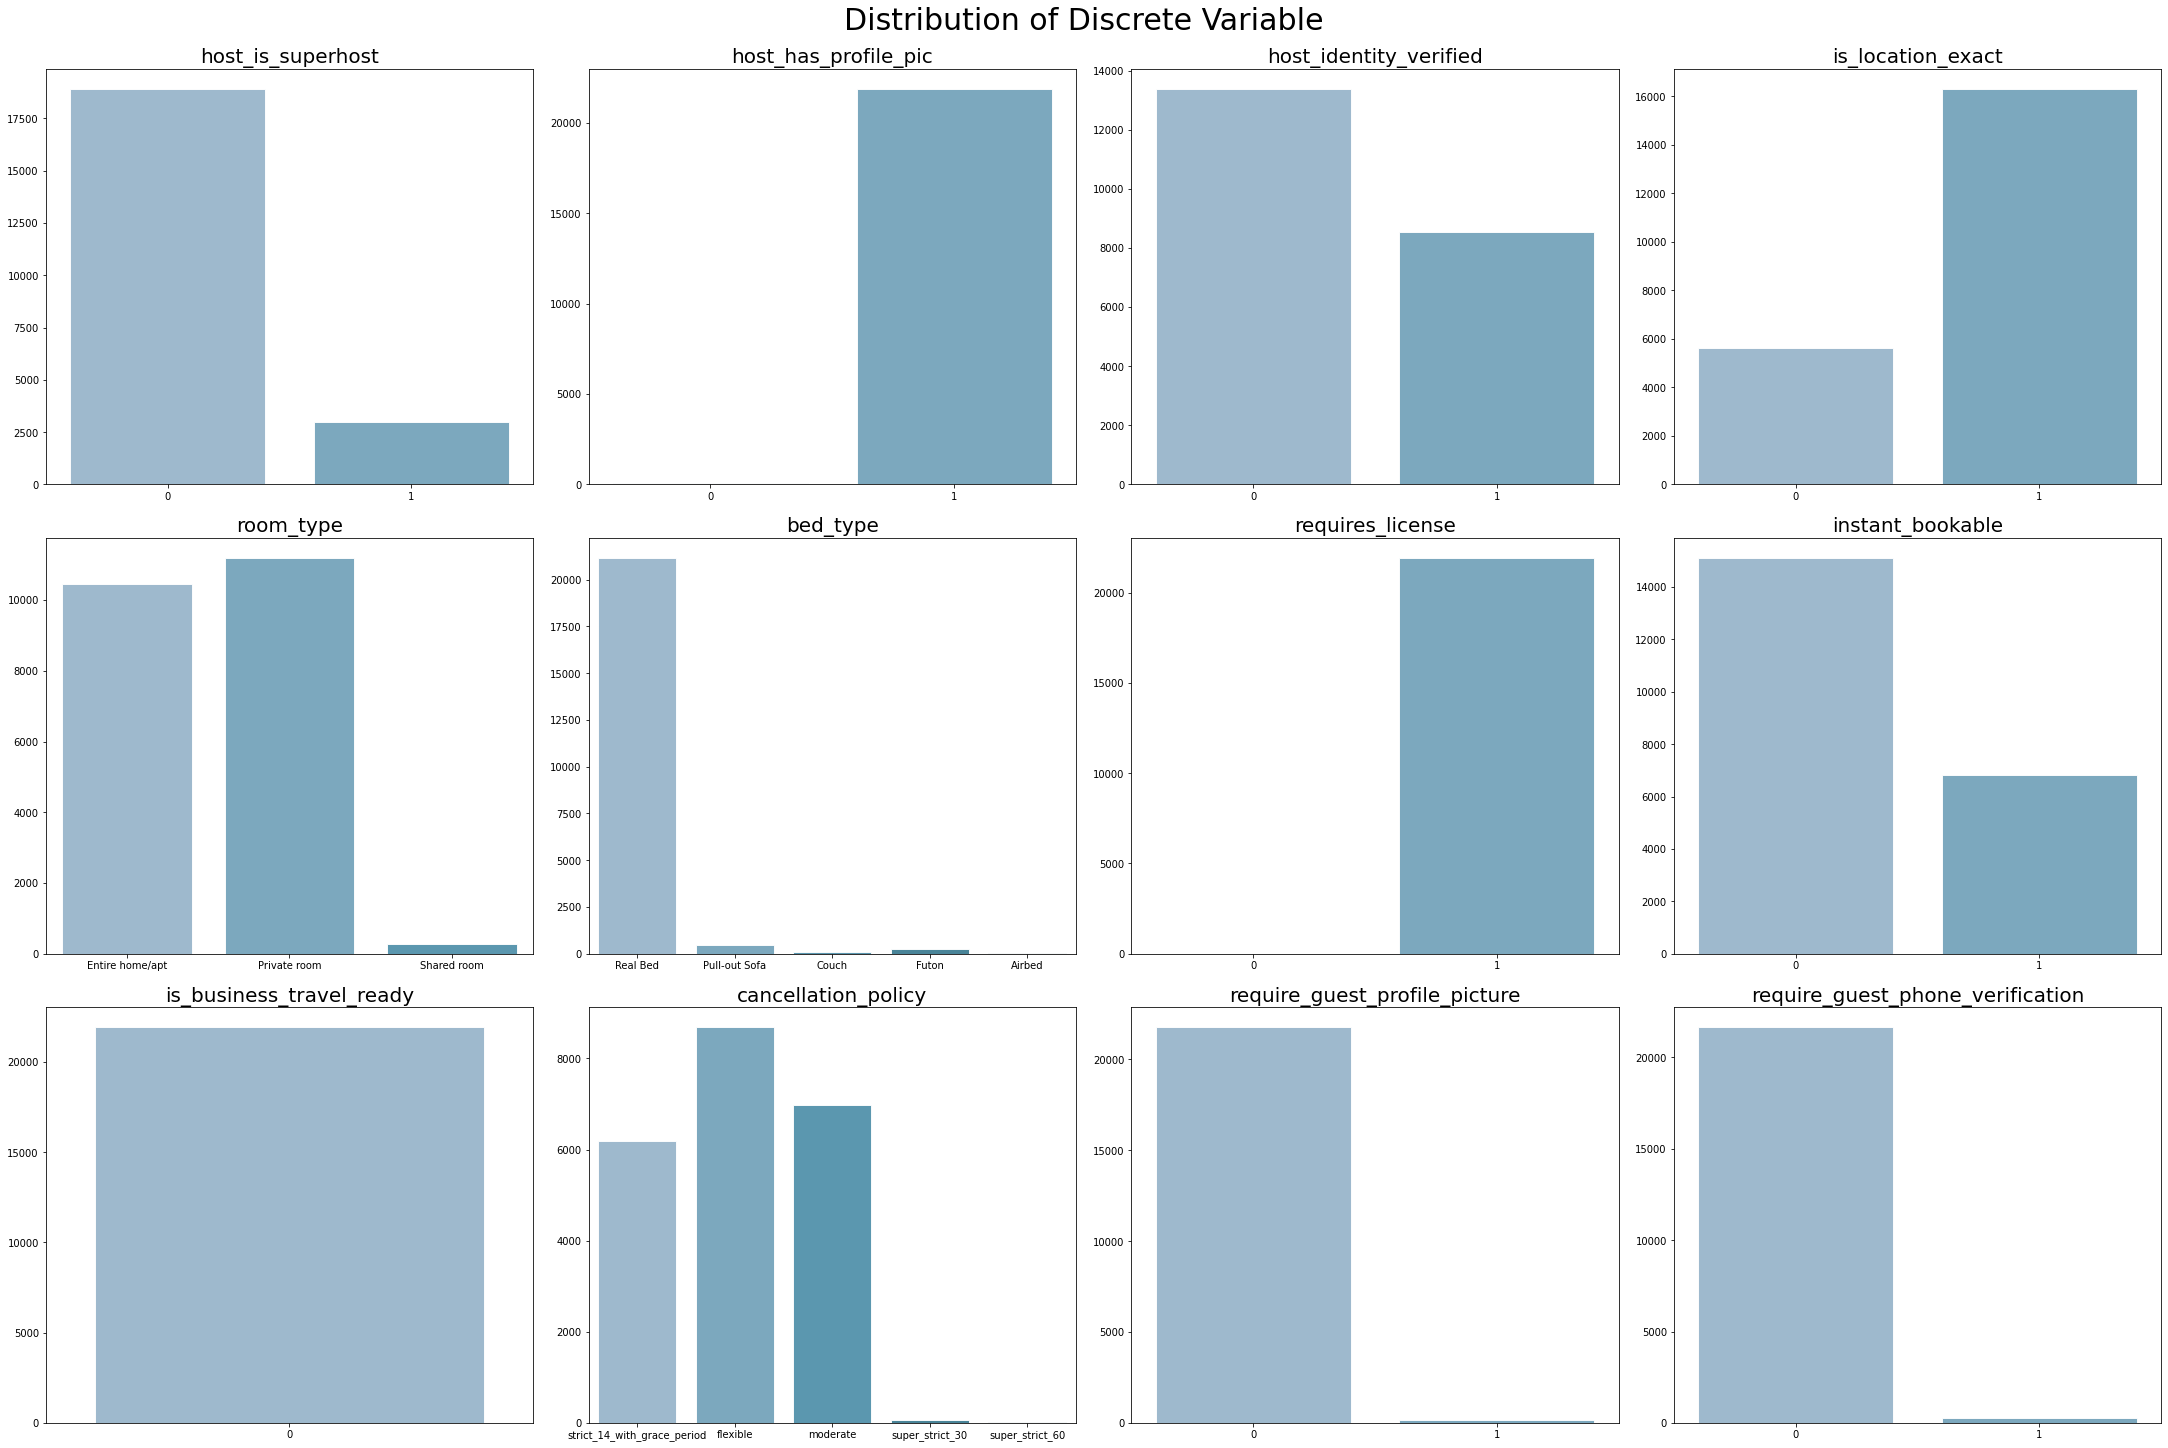

In [ ]:
partial_dum_col = host_dum_col + geo_dum_col + room_dum_col + other_dum_col

# 設定 subplot 畫布
fig, axs = plt.subplots(3, 4, figsize=(30, 20), constrained_layout=True)
fig.suptitle('Distribution of Discrete Variable', fontsize=30)

counter = 0
for col in partial_dum_col:
    if len(df[col].unique()) < 10:
        dct = dict()
        # 計算欄位中每一個 type 的種類。
        for val in df[col].unique():
            val = replace_nan(val)
            if len(df[df[col] == val]) != 0:
                if val == 't':
                    dct["True"] = len(df[df[col] == val])
                elif val == "f":
                    dct["False"] = len(df[df[col] == val])
                else:
                    dct[val] = len(df[df[col] == val])
                
        # 繪製在對應的位置
        sns.set(style="darkgrid")
        sns.color_palette("Spectral", as_cmap=True)
        x, y = [], []
        if "True" in dct.keys() and "False" in dct.keys():
            x = ["True", "False"]
            y = [dct["True"], dct["False"]]
        else:
            x = [ _ for _ in dct.keys()]
            y = [ _ for _ in dct.values()]
        sns.set_palette("PuBuGn_d")
        sns.barplot(x, y, alpha=0.9,ax = axs[counter//4][counter%4])
        axs[counter//4][counter%4].set_title(col, fontsize=20)
        counter += 1
plt.show()

In [ ]:
fig.savefig('discrete.png', dpi=500)

#### 地理分佈

AirBnB 在 berlin 的地理分佈

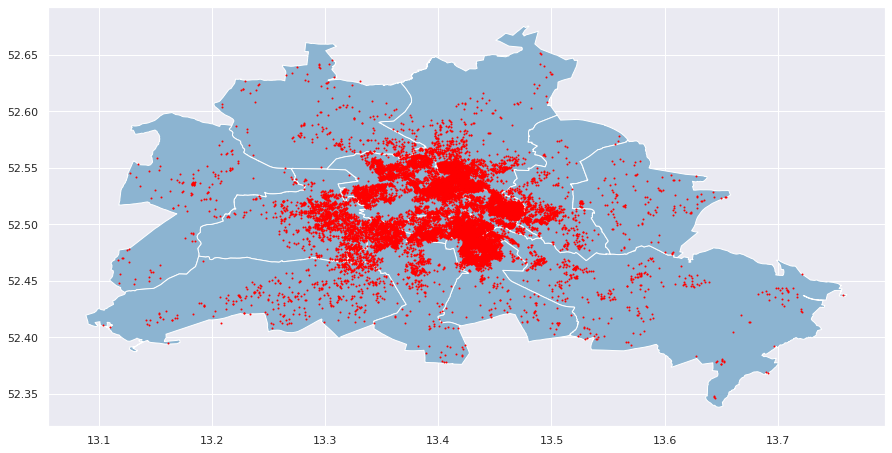

In [ ]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   
berlin = gpd.read_file('./archive/bezirksgrenzen.shp', encoding="utf-8")
gdf.plot(ax=berlin.plot(figsize=(15, 10)), marker='o', color='red', markersize=1);

Airbnb Price在Berlin的分佈

In [ ]:
mean_price = pd.merge(df.groupby("prog_name")["price"].mean(), berlin, on="prog_name")
mean_price = GeoDataFrame(mean_price)

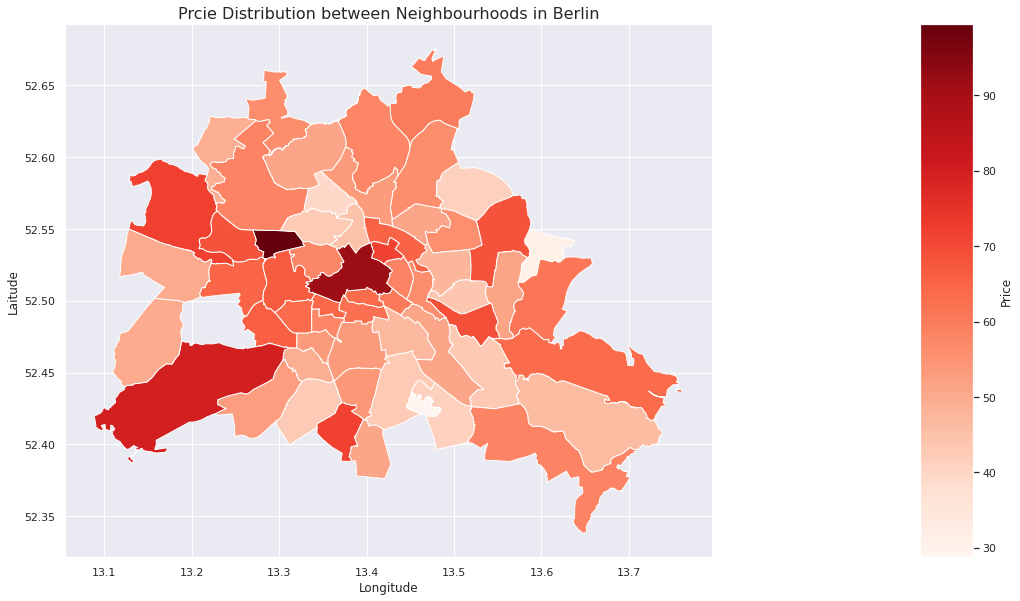

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.set_title('Prcie Distribution between Neighbourhoods in Berlin', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Laitude')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%")
mean_price.plot(column='price', ax=ax, legend=True, cmap='Reds', cax=cax, 
                  legend_kwds={'label': "Price"})

### Numerical Columns


In [ ]:
df.describe()

,host_since,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
count,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,2.193600e+04,21936.000000,21936.0,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.000000,21936.0,21936.000000,21936.000000,21936.000000,21936.000000
mean,1349.114241,0.398307,0.137035,2.350064,2.350064,0.997629,0.389497,52.509855,13.406094,0.744210,2.643736,1.093021,1.162381,1.624043,60.310403,118.549189,18.359136,1.336570,8.342177,7.137445,1.059275e+05,235.306528,1.0,4.966129,11.206966,20.138220,80.453729,18.289980,94.434775,9.665357,9.325349,9.714151,9.732020,9.506307,9.412868,0.999635,0.310950,0.0,0.007066,0.012582,1.929340,0.958011
std,698.065587,0.473178,0.343892,20.211493,20.211493,0.048631,0.487647,0.030797,0.057930,0.436314,1.515828,0.331187,0.646274,1.180235,69.222354,304.627880,24.997645,0.841918,11.165840,40.716623,9.774934e+06,495.366531,0.0,8.664409,17.492129,28.316073,119.464061,37.163289,6.850383,0.664676,0.934744,0.635405,0.618678,0.689571,0.758923,0.019094,0.462893,0.0,0.083764,0.111464,3.704743,1.449087
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.346203,13.103557,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
25%,854.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,52.489100,13.375632,0.000000,2.000000,1.000000,1.000000,1.000000,30.000000,0.000000,0.000000,1.000000,0.000000,2.000000,2.000000e+01,7.000000,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,93.000000,9.665357,9.000000,9.714151,9.732020,9.000000,9.000000,1.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.070000
50%,1291.500000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,52.509118,13.416785,1.000000,2.000000,1.000000,1.000000,1.000000,45.000000,0.000000,10.000000,1.000000,5.000000,2.000000,1.124000e+03,60.000000,1.0,0.000000,0.000000,0.000000,4.000000,5.000000,95.000000,10.000000,9.325349,10.000000,10.000000,10.000000,9.412868,1.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.360000
75%,1853.000000,1.000000,0.000000,2.000000,2.000000,1.000000,1.000000,52.532686,13.439258,1.000000,3.000000,1.000000,1.000000,2.000000,70.000000,150.000000,30.000000,1.000000,15.000000,4.000000,1.125000e+03,330.000000,1.0,6.000000,18.000000,36.000000,131.000000,17.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,0.0,0.000000,0.000000,1.000000,1.220000
max,3733.000000,1.000000,1.000000,1676.000000,1676.000000,1.000000,1.000000,52.651670,13.757642,1.000000,16.000000,8.500000,12.000000,22.000000,3000.000000,4280.000000,450.000000,16.000000,250.000000,5000.000000,1.000000e+09,9999.000000,1.0,30.000000,60.000000,90.000000,365.000000,498.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000

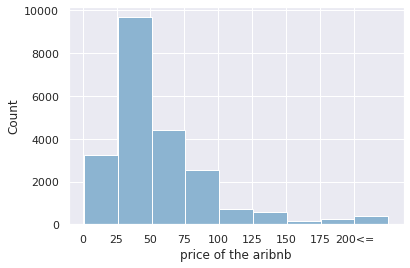

In [ ]:
# 出租價格(price)的分佈
price_lst = list(df["price"])

for index, value in enumerate(price_lst):
    if value > 200:
        price_lst[index] = 225

label = [str(i) for i in range(0,200, 25)]
label.append("200<=")
# Start ploting
plt.hist(price_lst, bins = 9)
plt.xticks(range(0,201, 25), label)
plt.xlabel("price of the aribnb")
plt.ylabel("Count")
plt.show()

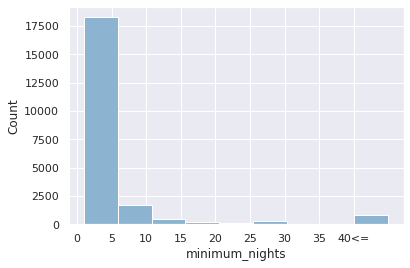

In [ ]:
# minimum_nights 
minimum_nights = list(df["minimum_nights"])

for index, value in enumerate(minimum_nights):
    if value >= 40:
        minimum_nights[index] = 45

label = [str(i) for i in range(0, 40, 5)]
label.append("40<=")

# Start ploting
plt.hist(minimum_nights, bins=9)
plt.xticks(range(0, 41, 5), label)
plt.xlabel("minimum_nights")
plt.ylabel("Count")
plt.show()

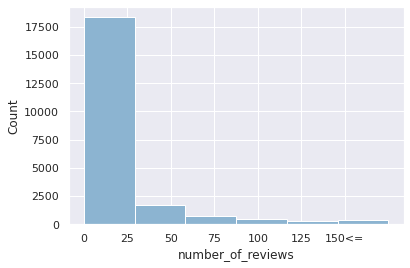

In [ ]:
# 每間 airbnb 的 review 總數量
number_of_reviews = list(df["number_of_reviews"])

for index, value in enumerate(number_of_reviews):
    if value > 150:
        number_of_reviews[index] = 175

label = [str(i) for i in range(0, 151, 25)]
label[-1] = "150<="

# Start ploting
plt.hist(number_of_reviews, bins=6)
plt.xticks(range(0, 151, 25), label)
plt.xlabel("number_of_reviews")
plt.ylabel("Count")
plt.show()

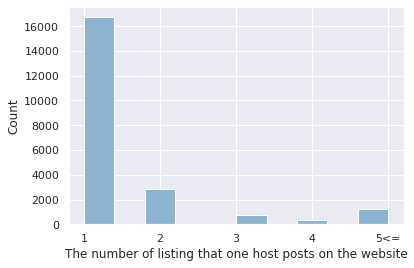

In [ ]:
# calculated_host_listings_count
num_listing = list(df["calculated_host_listings_count"])

for index, value in enumerate(num_listing):
    if value >= 5:
        num_listing[index] = 5

plt.hist(num_listing)
plt.xticks(range(1,6), ['1','2','3','4','5<='])
plt.xlabel("The number of listing that one host posts on the website")
plt.ylabel("Count")
plt.show()

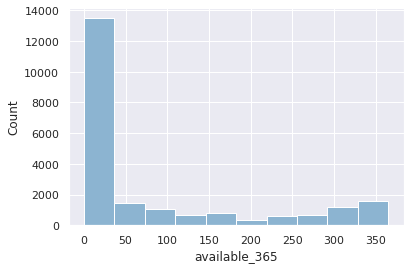

In [ ]:
# availability_365
available_365 = list(df["availability_365"])

plt.hist(available_365)
plt.xticks(range(0, 365, 50))
plt.xlabel("available_365")
plt.ylabel("Count")
plt.show()

## Get Dummy

In [ ]:
# 類別變數轉換
'''
1. 有缺值: neighbourhood, host_response_time, 
2. 沒有缺值、要刪欄位: host_neighbourhood, neighbourhood_cleansed, property_type, bed_type
3. 沒有缺值、不用刪欄位: neighbourhood_group_cleansed, room_type, cancellation_policy
4. 特殊: calendar_updated
'''
def get_dummy(dummy_df, colname, dummy_na, drop_first):
  dummy_df = pd.get_dummies(df[colname], dummy_na=dummy_na, drop_first=drop_first, prefix=colname)
  for col in dummy_df.columns:
    if dummy_df[col].sum() < df.shape[0] * 0.01:  # 去除掉比例低的項目
      dummy_df.drop([col], axis=1, inplace=True)
  new_df = pd.concat([df, dummy_df], axis=1)
  new_df.drop([colname], axis=1, inplace=True)
  return new_df

df = get_dummy(df, 'neighbourhood', dummy_na=True, drop_first=False)
df = get_dummy(df, 'host_response_time', dummy_na=False, drop_first=False)
df = get_dummy(df, 'host_neighbourhood', dummy_na=False, drop_first=False)
df = get_dummy(df, 'neighbourhood_cleansed', dummy_na=False, drop_first=False)
df = get_dummy(df, 'property_type', dummy_na=False, drop_first=False)
df = get_dummy(df, 'bed_type', dummy_na=False, drop_first=False)
df = get_dummy(df, 'neighbourhood_group_cleansed', dummy_na=False, drop_first=True)
df = get_dummy(df, 'room_type', dummy_na=False, drop_first=True)
df = get_dummy(df, 'cancellation_policy', dummy_na=False, drop_first=True)
df = get_dummy(df, 'prog_name', dummy_na=True, drop_first=False)

In [ ]:
from mlxtend.preprocessing import TransactionEncoder

# host_verifications轉換成Dummies
host_verifications_list = df['host_verifications'].replace("[\[' \]]", '', regex=True).str.split(',').tolist()
te = TransactionEncoder()
te_array = te.fit(host_verifications_list).transform(host_verifications_list).astype(int)
te_columns = ['host_verifications_{}'.format(col) for col in te.columns_]
host_verifications = pd.DataFrame(te_array, columns=te_columns, index=df.index)
host_verifications['host_verifications_way_num'] = host_verifications.sum(axis=1)

# amenities轉換成Dummies
amenities_list = df['amenities'].replace('[\{" \}]', '', regex=True).str.split(',').tolist()
te = TransactionEncoder()
te_array = te.fit(amenities_list).transform(amenities_list).astype(int)
te_columns = ['amenities_{}'.format(col) for col in te.columns_]
amenities = pd.DataFrame(te_array, columns=te_columns, index=df.index)
amenities['amenities_way_num'] = amenities.sum(axis=1)

In [ ]:
for col in host_verifications.columns:
  if host_verifications[col].sum() < host_verifications.shape[0] * 0.01:  # 去除掉比例低的項目
    host_verifications.drop([col], axis=1, inplace=True)

for col in amenities.columns:
  if amenities[col].sum() < amenities.shape[0] * 0.01:  # 去除掉比例低的項目
    amenities.drop([col], axis=1, inplace=True)

df = pd.concat([df, host_verifications], axis=1)
df = pd.concat([df, amenities], axis=1)
df.drop(['host_verifications', 'amenities'], axis=1, inplace=True)

In [ ]:
df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False).to_frame(name='Number of NA')

,Number of NA


In [ ]:
print(df.shape)
df.head()  # 2018-11-07

(21936, 248)


,host_since,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,...,amenities_Lockbox,amenities_Lockonbedroomdoor,amenities_Longtermstaysallowed,amenities_Luggagedropoffallowed,amenities_Microwave,amenities_Other,amenities_Outletcovers,amenities_Oven,amenities_Pack’nPlay/travelcrib,amenities_Paidparkingoffpremises,amenities_Paidparkingonpremises,amenities_Patioorbalcony,amenities_Petsallowed,amenities_Petsliveonthisproperty,amenities_Privateentrance,amenities_Privatelivingroom,amenities_Refrigerator,amenities_Room-darkeningshades,amenities_Safetycard,amenities_Selfcheck-in,amenities_Shampoo,amenities_Singlelevelhome,amenities_Smokedetector,amenities_Smokingallowed,amenities_Step-freeaccess,amenities_Stove,amenities_Suitableforevents,amenities_TV,amenities_Washer,amenities_Well-litpathtoentrance,amenities_Wheelchairaccessible,amenities_Wideclearancetobed,amenities_Widedoorway,amenities_Wideentryway,amenities_Widehallwayclearance,amenities_Wifi,amenities_Windowguards,amenities_translationmissing:en.hosting_amenity_49,amenities_translationmissing:en.hosting_amenity_50,amenities_way_num
0,3733.0,0.96,1,4.0,4.0,1,1,52.534537,13.402557,0,3,1.0,1.0,2.0,60.0,200.0,30.0,1,28.0,4,1125,90,1,0,21,51,141,118,93.0,10.0,9.0,10.0,10.0,10.0,9.0,1,0,0,0,0,...,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,29
1,3704.0,0.00,0,1.0,1.0,1,1,52.548513,13.404553,1,2,1.0,1.0,1.0,17.0,0.0,0.0,1,0.0,2,40,49,1,0,0,0,0,6,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,10
2,3671.0,1.00,0,1.0,1.0,1,1,52.534996,13.417579,1,4,1.0,1.0,2.0,90.0,200.0,50.0,2,20.0,62,1125,7,1,0,0,0,220,143,92.0,9.0,9.0,9.0,9.0,10.0,9.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,19
3,3652.0,0.00,0,1.0,1.0,1,1,52.498855,13.349065,1,2,1.0,1.0,1.0,26.0,250.0,30.0,1,18.0,5,360,28,1,0,0,22,297,25,88.0,9.0,9.0,9.0,10.0,9.0,9.0,1,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,29
4,3462.0,1.00,1,1.0,1.0,1,1,52.543157,13.415091,1,2,1.0,1.0,2.0,42.0,0.0,0.0,1,24.0,2,10,3,1,15,26,26,26,197,96.0,10.0,10.0,10.0,10.0,10.0,9.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,13


## Save listing_sum_df.csv
Next：加Description分數，與其合併。

In [ ]:
!gdown --id "1XEsMoAKUg10YkYI-VYmVCWhyzVpwwJnI"

In [ ]:
df.to_csv("listings_summary_cleaned.csv")